In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error

In [2]:
# 1. Importar el df del otro script
import limpieza
df = limpieza.df_transformado

Las columnas de alquiler y compra son las mismas? -->  True
Hay 3 registros duplicados en df. Se muestran en el df_duplicados
Se han eliminado los duplicados
Análisis de la columna bathrooms
Valores únicos:
['1', '2', '3', '4', '6']

Conteo de valores:
bathrooms
1    452
2    275
3     38
4      9
6      1
Name: count, dtype: int64

Resumen:
count    775.000000
mean       1.494194
std        0.666399
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        6.000000
Name: bathrooms, dtype: float64

Valores nulos: 0

--------------------------------------------------

Análisis de la columna exterior
Valores únicos:
['False', 'True', 'nan']

Conteo de valores:
exterior
True     692
False     51
Name: count, dtype: int64

Resumen:
count      743
unique       2
top       True
freq       692
Name: exterior, dtype: object

Valores nulos: 32

--------------------------------------------------

Análisis de la columna floor
Valores únicos:
['1', '10', '12', '13'

In [3]:
# 2. Separar la variable objetivo ('price') y las variables independientes
X = df.drop('price', axis=1)
y = df['price']

# 3. Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# 4. Escalar las variables numéricas si es necesario
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
# 5. Crear el modelo de Random Forest
random_forest_regressor = RandomForestRegressor()
#{'bootstrap': False, 'ccp_alpha': 0.01, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

In [7]:
# GRID SEARCH 

param_grid = {
    'n_estimators': [100, 200],
    'criterion': ['squared_error', 'absolute_error'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'max_leaf_nodes': [None, 10, 20],
    'min_impurity_decrease': [0.0, 0.1],
    'ccp_alpha': [0.0, 0.01]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=random_forest_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Ejecutar GridSearchCV
grid_search.fit(X, y)


Fitting 5 folds for each of 3456 candidates, totalling 17280 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'ccp_alpha': [0.0, 0.01],
                         'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [10, 20, None],
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [None, 10, 20],
                         'min_impurity_decrease': [0.0, 0.1],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error', verbose=2)

In [12]:
# Mejor combinación de hiperparámetros encontrada
print("Mejores hiperparámetros:", grid_search.best_params_)

# Mejor modelo entrenado
best_model_random_forest = grid_search.best_estimator_

Mejores hiperparámetros: {'bootstrap': False, 'ccp_alpha': 0.01, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [ ]:
'bootstrap': False, 
'ccp_alpha': 0.01,
'max_features': 'log2', 
'min_impurity_decrease': 0.1, 
'min_samples_split': 5, 


In [14]:
# 6. Validación cruzada
rmse_scorer = make_scorer(mean_squared_error, squared=False)  # Definir el RMSE como métrica
cv_scores = cross_val_score(best_model_random_forest, X_train_scaled, y_train, cv=10, scoring=rmse_scorer)

# Mostrar resultados de la validación cruzada
print(f"RMSE scores for each fold: {cv_scores}")
print(f"Mean RMSE: {cv_scores.mean():.2f}")
print(f"Standard Deviation of RMSE: {cv_scores.std():.2f}")

# 7. Entrenar el modelo en todos los datos de entrenamiento
best_model_random_forest.fit(X_train_scaled, y_train)

# 8. Hacer predicciones y evaluar el modelo
y_pred = best_model_random_forest.predict(X_test_scaled)
df_resultados = pd.DataFrame({'Real': y_test, 
                              'Predicted': y_pred, 
                              'PorcentajeError': abs((y_pred - y_test) / y_test) * 100})
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Final Root Mean Squared Error on Test Set: {rmse:.2f}")

RMSE scores for each fold: [281.71043155 208.04477271 418.19320049 296.97918257 232.65824547
 292.29283751 163.36628842 217.18949787 166.28039225 223.2651896 ]
Mean RMSE: 250.00
Standard Deviation of RMSE: 71.87
Final Root Mean Squared Error on Test Set: 334.78


In [16]:
# Extraer los resultados
results = grid_search.cv_results_

# Convertir a un DataFrame de Pandas
import pandas as pd
df_results = pd.DataFrame(results)

# Seleccionar las columnas relevantes y crear una tabla pivote
scores = df_results.pivot_table(values='mean_test_score', 
                                index='param_max_depth', 
                                columns='param_min_samples_split')

# Convertir las puntuaciones negativas a positivas para que sean más interpretables
scores = -1 * scores


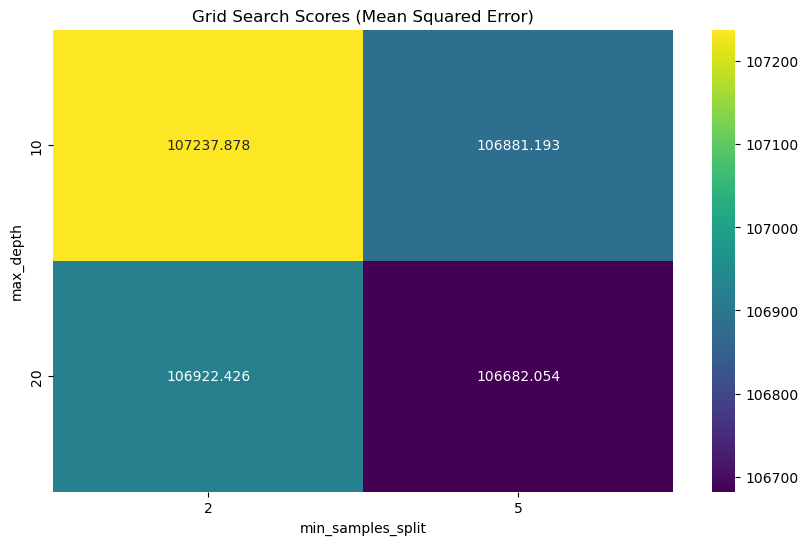

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(scores, annot=True, fmt=".3f", cmap="viridis")
plt.title("Grid Search Scores (Mean Squared Error)")
plt.xlabel("min_samples_split")
plt.ylabel("max_depth")
plt.show()


In [1]:
# metricas 
import metricas 

ModuleNotFoundError: No module named 'metricas'